# SnapATAC Analysis

In [1]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2)
library(scales)
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapp

In [2]:
# Metadata file for scATAC
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
scatac_metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(scatac_metaData) = paste(scatac_metaData$sample, scatac_metaData$barcode, sep='_')
scatac_metaData$cells = rownames(scatac_metaData)
scatac_metaData = scatac_metaData[scatac_metaData$sample=="D2", ]
rownames(scatac_metaData) = scatac_metaData$barcode
dim(scatac_metaData)
head(scatac_metaData, 5)

[1] 6559    6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
AAACAACGAGAAGTTA,AAACAACGAGAAGTTA,D2,-2.582804,1.0539784,10,D2_AAACAACGAGAAGTTA
AAACAACGAGACTGTT,AAACAACGAGACTGTT,D2,-3.609249,0.2938383,15,D2_AAACAACGAGACTGTT
AAACCCTGAGTACGTT,AAACCCTGAGTACGTT,D2,-3.560982,-6.2913636,13,D2_AAACCCTGAGTACGTT
AAACCGTACCACCTAA,AAACCGTACCACCTAA,D2,-2.479006,-3.8390841,3,D2_AAACCGTACCACCTAA
AAACCGTACGCCCTAG,AAACCGTACGCCCTAG,D2,-3.901256,0.8696430,15,D2_AAACCGTACGCCCTAG


In [3]:
rev(sort(table(scatac_metaData$cluster)))


   3   13   15   11    2    1   14   10   12    7 
2122 1502 1123 1059  341  272   64   44   24    8 

In [4]:
head(names(rev(sort(table(scatac_metaData$cluster)))), 5)

[1] "3"  "13" "15" "11" "2"

In [5]:
# only keep those in top 5 clusters
scatac_metaData = scatac_metaData[scatac_metaData$cluster %in% as.numeric(head(names(rev(sort(table(scatac_metaData$cluster)))), 5)), ]
dim(scatac_metaData)

[1] 6147    6

In [6]:
rev(sort(table(scatac_metaData$cluster)))


   3   13   15   11    2 
2122 1502 1123 1059  341 

In [7]:
list.files("/srv/scratch/surag/scATAC-reprog/snap")

[1] "D2.snap"

In [8]:
DAYS = c("D1M", "D2M", "D2")
FILES = c("/srv/scratch/surag/scMultiome-reprog/snap/D1M.snap",
          "/srv/scratch/surag/scMultiome-reprog/snap/D2M.snap",
          "/srv/scratch/surag/scATAC-reprog/chromap/snap/D2.snap"
         )

BARCODES = c("./D1M.ATAC.bc.txt",
            "./D2M.ATAC.bc.txt",
            "../20200424_ArchR/barcodeLists/20210713_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25/D2.barcodes.txt")

file.list = FILES
barcode.file.list = BARCODES

DAYS
file.list
barcode.file.list

[1] "D1M" "D2M" "D2"

[1] "/srv/scratch/surag/scMultiome-reprog/snap/D1M.snap"   
[2] "/srv/scratch/surag/scMultiome-reprog/snap/D2M.snap"   
[3] "/srv/scratch/surag/scATAC-reprog/chromap/snap/D2.snap"

[1] "./D1M.ATAC.bc.txt"                                                                                      
[2] "./D2M.ATAC.bc.txt"                                                                                      
[3] "../20200424_ArchR/barcodeLists/20210713_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25/D2.barcodes.txt"

In [9]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [10]:
# Filter cells using previously selected barcodes (see 20200424_ArchR/DoubletAnalysis.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})

x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [16]:
# subset to barcodes in most common/interesting states
x.sp.list$D2 = x.sp.list$D2[x.sp.list$D2@barcode %in% rownames(scatac_metaData), ]

In [17]:
x.sp.list

$D1M
number of barcodes: 3217
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2M
number of barcodes: 4161
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 6147
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [18]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addBmatToSnap(x.sp.list[[i]], bin.size=5000, num.cores=5)
    x.sp
})

Epoch: reading cell-bin count matrix session ...

Epoch: reading cell-bin count matrix session ...

Epoch: reading cell-bin count matrix session ...



In [19]:
bin.shared = Reduce(intersect, lapply(x.sp.list, function(x.sp) x.sp@feature$name));

In [20]:
# merge timepoints
x.sp.list <- lapply(x.sp.list, function(x.sp){
    idy = match(bin.shared, x.sp@feature$name);
    x.sp[,idy, mat="bmat"];
  })
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [21]:
x.sp

number of barcodes: 13525
number of bins: 620094
number of genes: 0
number of peaks: 0
number of motifs: 0

In [22]:
rm(x.sp.list); # free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4524901,241.7,7569517,404.3,5704078,304.7
Vcells,224010948,1709.1,725669135,5536.5,1331178887,10156.1


In [23]:
# check if reads at OCT promoter (very few or none in initial version)
sum(x.sp@bmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), x.sp@feature))])

[1] 631

In [24]:
table(x.sp@sample)


 D1M   D2  D2M 
3217 6147 4161 

In [25]:
sum(x.sp@bmat[x.sp@sample=="D1M",subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), x.sp@feature))])
sum(x.sp@bmat[x.sp@sample=="D2M",subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), x.sp@feature))])
sum(x.sp@bmat[x.sp@sample=="D2",subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), x.sp@feature))])

[1] 212

[1] 214

[1] 205

In [26]:
x.sp = makeBinary(x.sp, mat="bmat");

In [27]:
tempCov = Matrix::rowSums(x.sp@bmat)

In [28]:
# these are fragments!
min(tempCov)

[1] 967

## Filtering bins

In [29]:
black_list = read.table("../../../resources/blacklist/GRch38_unified_blacklist.bed");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [30]:
idy = queryHits(findOverlaps(x.sp@feature, black_list.gr));

In [31]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};

In [32]:
chr.exclude = seqlevels(x.sp@feature)[grep("random|chrM|chrUn", seqlevels(x.sp@feature))];
idy = grep(paste(chr.exclude, collapse="|"), x.sp@feature);
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};

In [33]:
x.sp

number of barcodes: 13525
number of bins: 602724
number of genes: 0
number of peaks: 0
number of motifs: 0

number of barcodes: 13525
number of bins: 543652
number of genes: 0
number of peaks: 0
number of motifs: 0

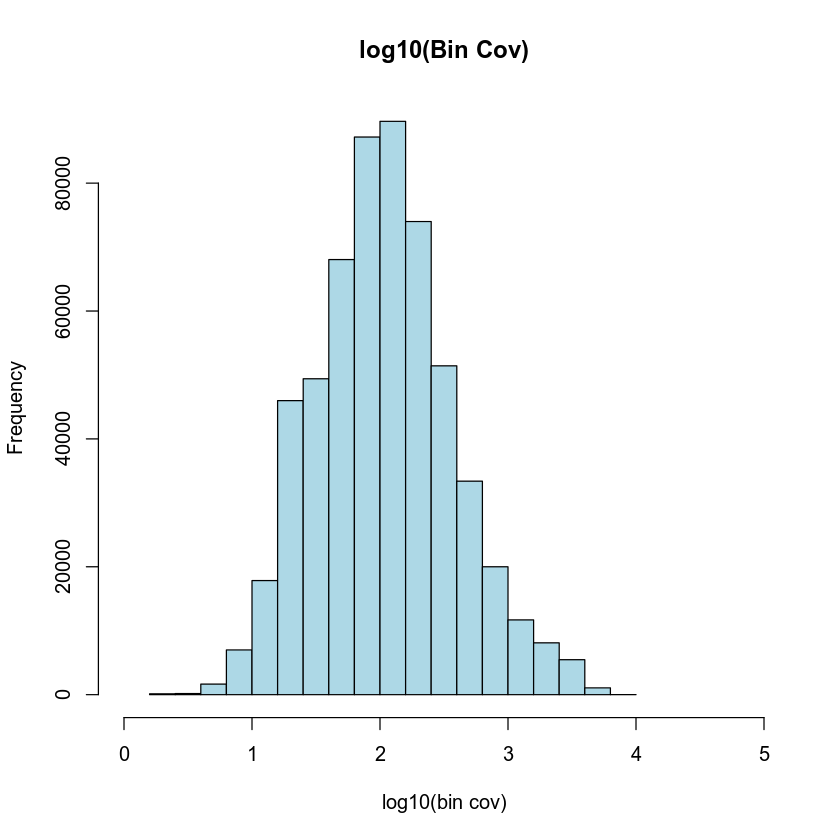

In [34]:
bin.cov = log10(Matrix::colSums(x.sp@bmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="bmat"];
x.sp

## Dim Reduction

In [35]:
rowCovs = Matrix::rowSums(x.sp@bmat)

In [37]:
table(x.sp@sample)


 D1M   D2  D2M 
3217 6147 4161 

In [38]:
x.sp = runDiffusionMaps(
    obj= x.sp,
    input.mat="bmat", 
    num.eigs=50
);

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



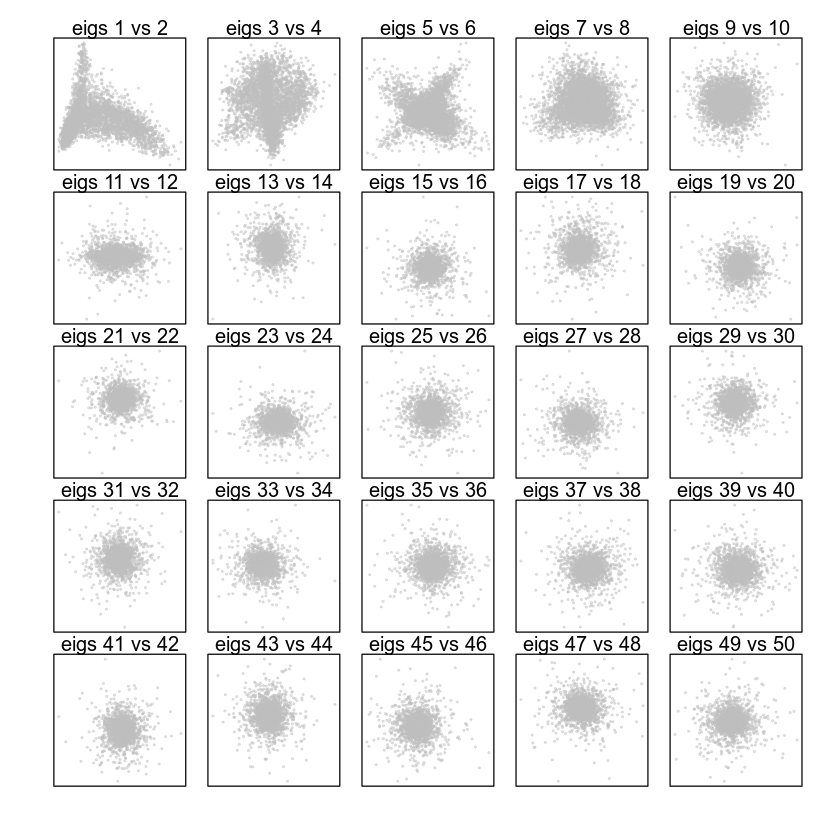

In [39]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [40]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:10,
    k=15
  );

In [41]:
library(leiden)

In [42]:
x.sp = runCluster(
   obj=x.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
#    resolution = 2.1,
   seed.use=1
);
x.sp@metaData$cluster = x.sp@cluster;

In [43]:
table(x.sp@cluster)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14 
1563 1528 1320 1282 1164  984  908  858  849  794  701  671  565  338 

In [44]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:10, 
    method="umap",
    seed.use=2,
    num.cores=10,
  );

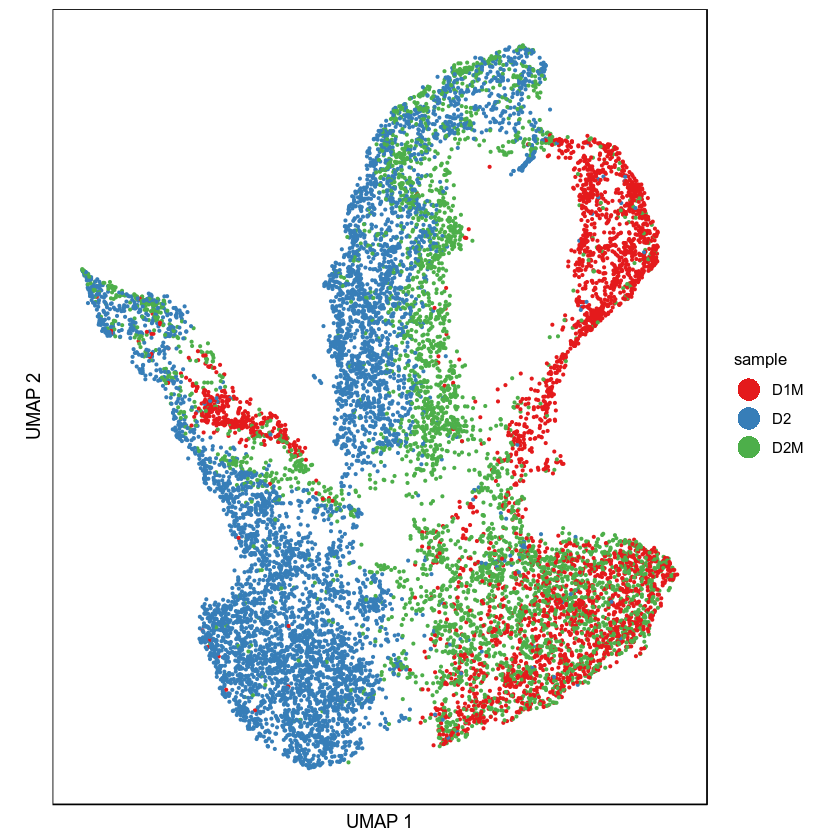

In [47]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, sample=x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=-umap.1 , y=-umap.2, col=sample)) +
scale_color_brewer( palette = "Set1") +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=6))) +
coord_fixed()

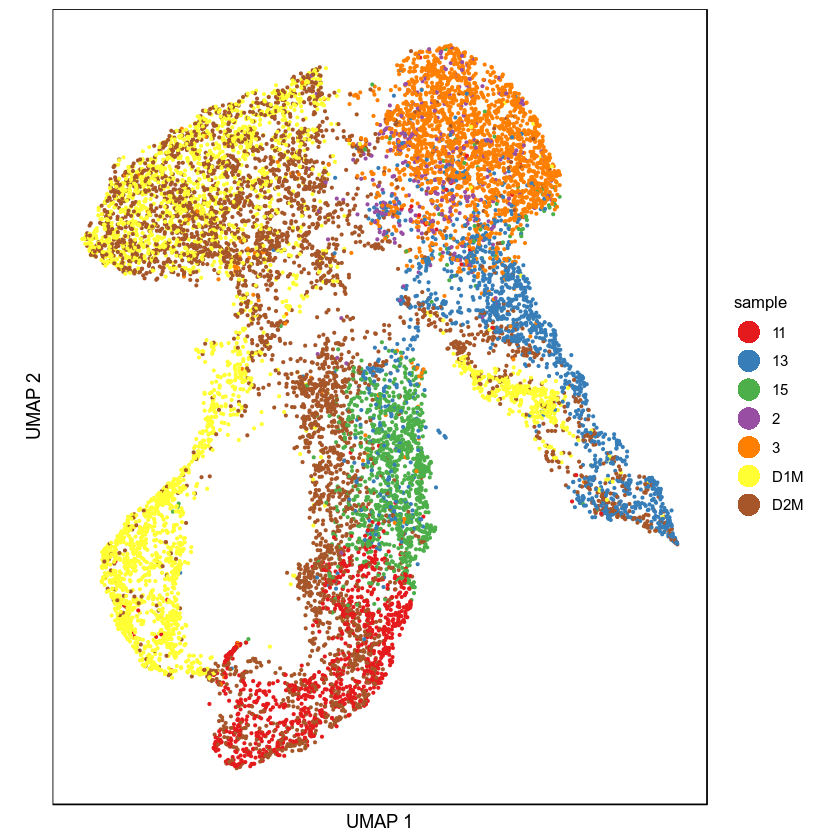

In [50]:
options(repr.plot.width = 7, repr.plot.height = 7+
coord_fixed())

sample_d2_clust = x.sp@sample
sample_d2_clust[sample_d2_clust=="D2"] = scatac_metaData[x.sp@barcode[x.sp@sample=="D2"], "cluster"]
sample_d2_clust[sample_d2_clust %in% names(table(sample_d2_clust))[table(sample_d2_clust) < 100]] = "other"
df = data.frame(x.sp@umap, sample=sample_d2_clust)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap.1 , y=umap.2, col=sample)) +
scale_color_brewer( palette = "Set1") +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=6)))+
coord_fixed()

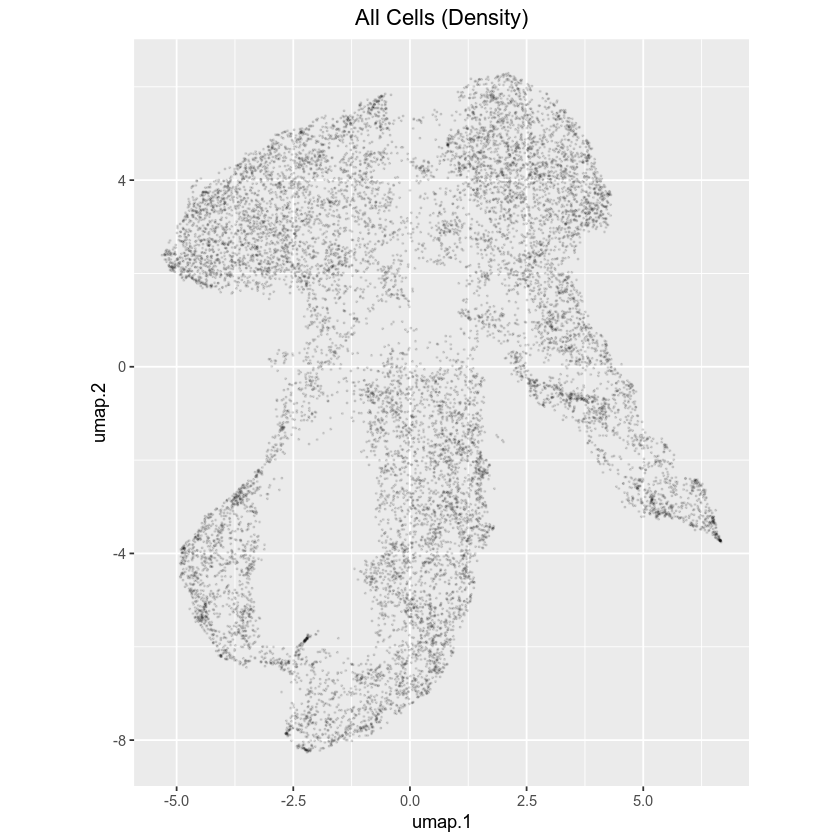

In [49]:
df = data.frame(x.sp@umap, x.sp@sample)

ggplot(df) +
geom_point(shape=20, size=0.5, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
ggtitle("All Cells (Density)") + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

In [51]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

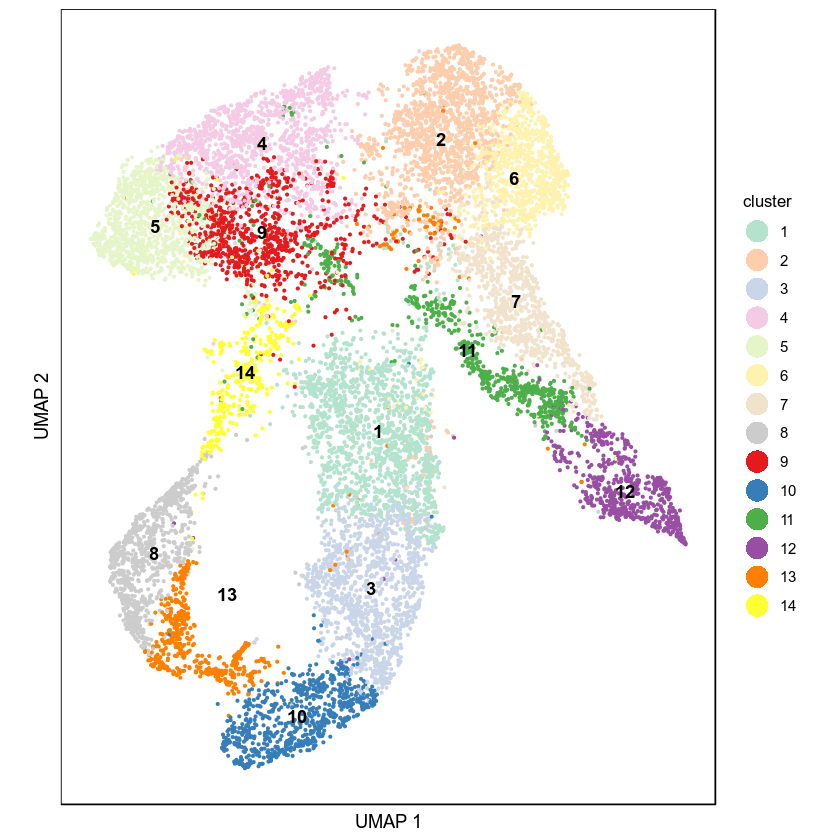

In [52]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, 
                cluster=x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap.1 , y=umap.2, col=cluster)) +
scale_colour_manual(values = col_vector[seq(38,length(col_vector))]) +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
geom_text(data=data.frame(aggregate(x.sp@umap, 
                                    list(x.sp@cluster), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold")  +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=6)))+
coord_fixed()


### Harmony

In [53]:
batch = ifelse(x.sp@sample == "D2", "ATAC", "Multiome")
table(batch)

batch
    ATAC Multiome 
    6147     7378 

In [54]:
attributes(x.sp)$batch = batch

In [55]:
table(x.sp@batch)


    ATAC Multiome 
    6147     7378 

In [90]:
x.sp.harmony = runHarmony(
    obj=x.sp, 
    eigs.dim=1:10, 
    meta_data=batch, # sample index
  );

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



In [91]:
dim(x.sp.harmony@smat@dmat)

[1] 13525    10

In [92]:
x.sp.harmony = runKNN(
    obj= x.sp.harmony,
    eigs.dim=1:10,
    k=15
  );

In [93]:
x.sp.harmony = runCluster(
   obj=x.sp.harmony,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
   resolution = .5,
   seed.use=1
);
x.sp.harmony@metaData$cluster = x.sp.harmony@cluster;

In [94]:
x.sp.harmony = runViz(
    obj=x.sp.harmony, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:10, 
    method="umap",
    seed.use=2,
    num.cores=10,
  );

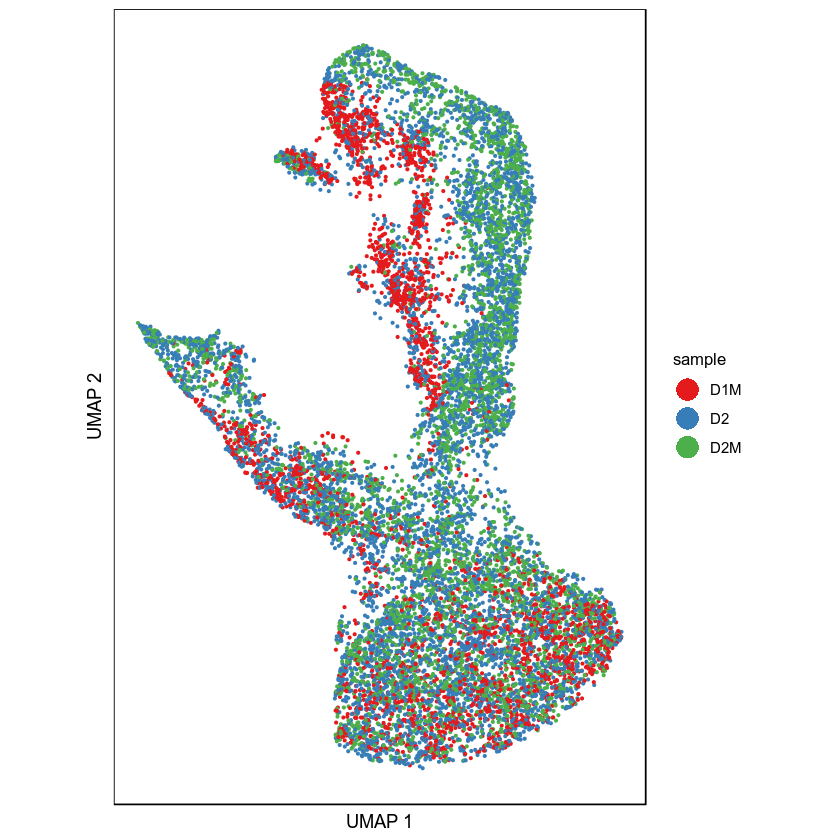

In [98]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp.harmony@umap, sample=x.sp.harmony@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap.1 , y=umap.2, col=sample)) +
scale_color_brewer( palette = "Set1") +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=6))) +
coord_fixed()

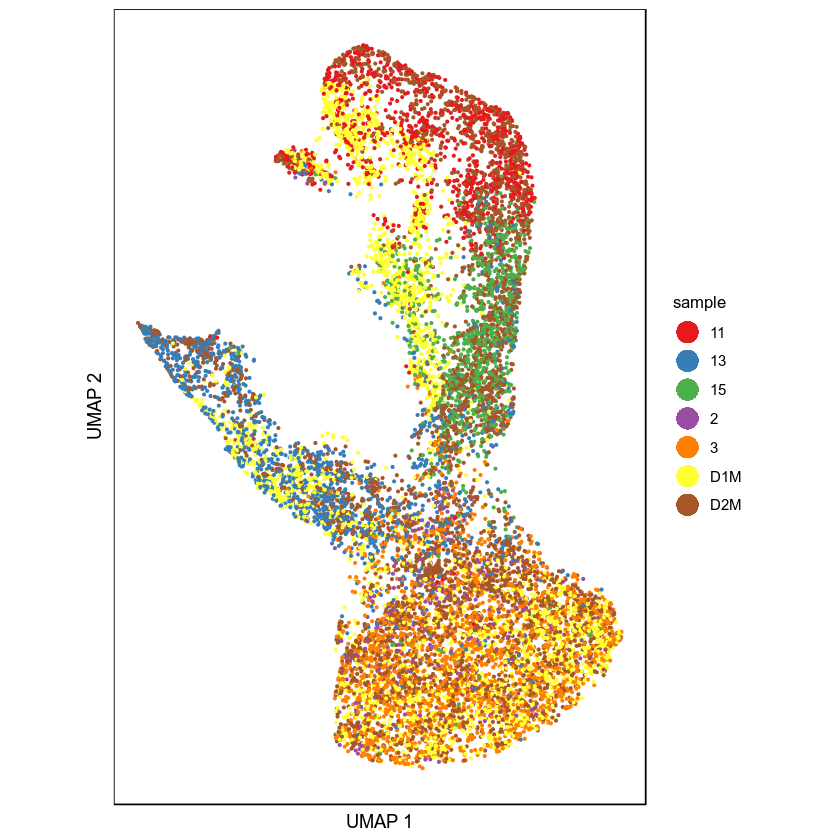

In [99]:
options(repr.plot.width = 7, repr.plot.height = 7)

sample_d2_clust = x.sp@sample
sample_d2_clust[sample_d2_clust=="D2"] = scatac_metaData[x.sp@barcode[x.sp@sample=="D2"], "cluster"]
sample_d2_clust[sample_d2_clust %in% names(table(sample_d2_clust))[table(sample_d2_clust) < 100]] = "other"

df = data.frame(x.sp.harmony@umap, sample=sample_d2_clust)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap.1 , y=umap.2, col=sample)) +
scale_color_brewer( palette = "Set1") +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=6))) +
coord_fixed()

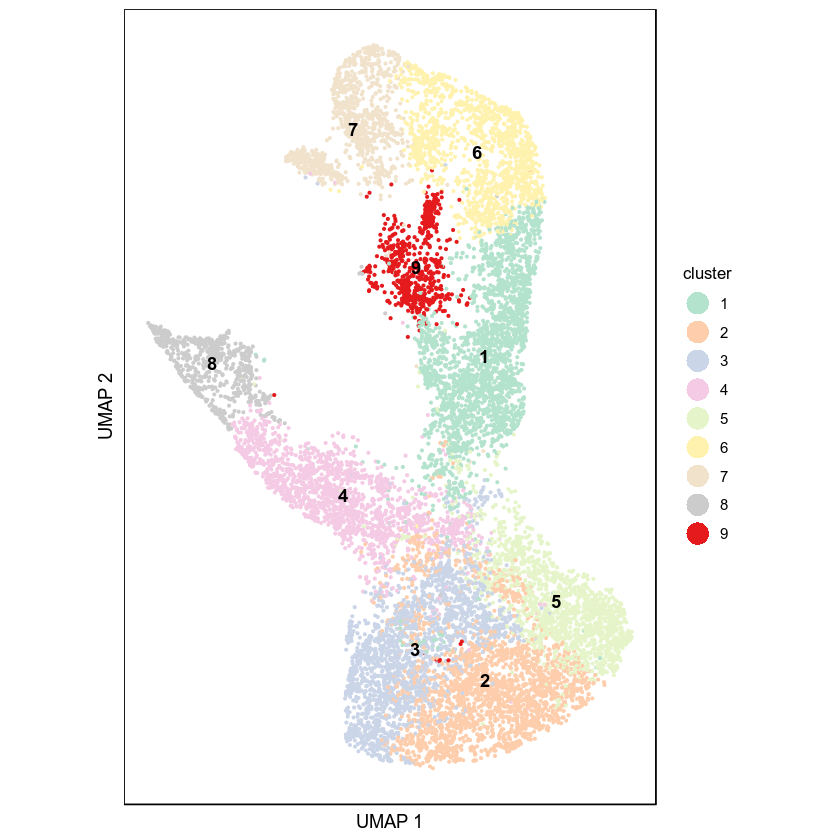

In [100]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp.harmony@umap, 
                cluster=x.sp.harmony@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap.1 , y=umap.2, col=cluster)) +
scale_colour_manual(values = col_vector[seq(38,length(col_vector))]) +
# ggtitle("All Cells (Day)") + 
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
geom_text(data=data.frame(aggregate(x.sp.harmony@umap, 
                                    list(x.sp.harmony@cluster), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold")  +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=6))) +
coord_fixed()

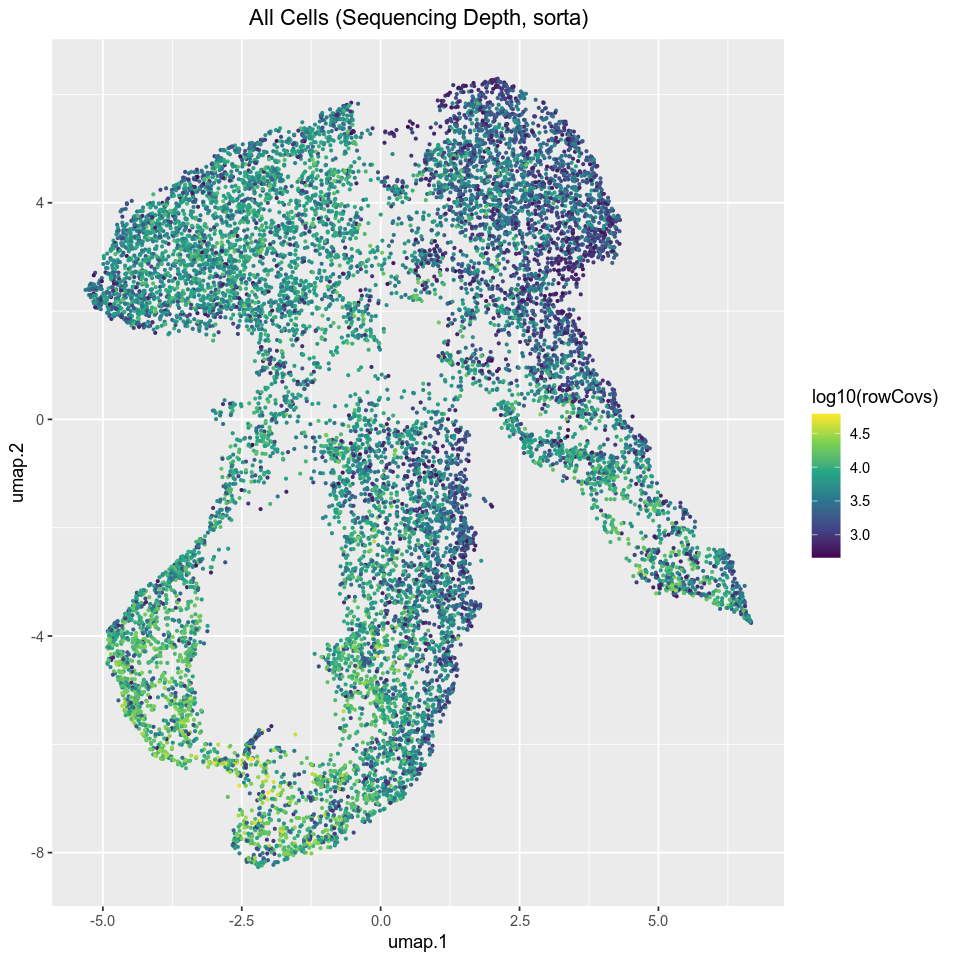

In [106]:
options(repr.plot.width = 8, repr.plot.height = 8)

df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(size=0.5, alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

## Export Meta Data for Session

In [102]:
x.sp

number of barcodes: 13525
number of bins: 543652
number of genes: 0
number of peaks: 0
number of motifs: 0

In [103]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

# if you've manually changed the clusters, make sure to update them at x.sp@metaData$cluster
# myExportMetaData(x.sp, "./snapATAC_sessions/20200501_n76052/metadata.tsv", slot.names=c('barcode', 'cluster', 'umap', 'metaData', 'sample'))
myExportMetaData(x.sp.harmony, "./sessions/20220612_n13525/metadata.tsv", slot.names=c('metaData', 'umap', 'sample'))

In [104]:
# re-add non-binarized cell-by-bin matrix
x.sp.harmony.raw = addBmatToSnap(x.sp.harmony);

Epoch: reading cell-bin count matrix session ...



In [75]:
x.sp.harmony.raw

number of barcodes: 13525
number of bins: 620094
number of genes: 0
number of peaks: 0
number of motifs: 0

In [77]:
writeMM(x.sp.harmony.raw@bmat, file="./sessions/20220612_n13525/5kb.sparse.mm")

NULL

In [78]:
# writing ranges for 5kb and sparse matrix
write.table(data.frame(seqnames=seqnames(x.sp.harmony.raw@feature),
                       starts=start(x.sp.harmony.raw@feature)-1,
                       ends=end(x.sp.harmony.raw@feature)),
            file="./sessions/20220612_n13525/5kb.ranges.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [105]:
write.table(x.sp.harmony@smat@dmat, "./sessions/20220612_n13525/features.harmony.10d.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

In [80]:
dim(x.sp@smat@dmat)

[1] 13525    50

In [81]:
write.table(x.sp@smat@dmat, "./sessions/20220612_n13525/features.no.harmony.50d.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

---

In [82]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/snapATAC/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] harmony_1.0          Rcpp_1.0.4.6         RColorBrewer_1.1-2  
 [4] leiden_0.3.3         scales_1.1.0         ggplot2_3.3.0       
 [7] GenomicRanges_1.34.0 GenomeInfoDb_1.18.2  IRanges_2.16.0      
[10] S4Vectors_0.20.1     BiocGenerics_0.28.0  SnapATAC_1.0.0      
[13] r